<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

***Цель исследования:*** проанализировать поведение клиентов и спрогнозировать отток.

***Ход исследования:***

* Изучим и предобработаем данные.
* Разделим исходные данные на обучающую, валидационную и тестовую выборки.
* Исследуем качество разных моделей, меняя гиперпараметры. Кратко опишем выводы исследования.
* Проверим качество модели на тестовой выборке.
* Проверим модели на вменяемость.

## Подготовка данных

В первую ячейку будем импортировать библиотеки которы понадобятся в ходе выполнения проекта.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

С помощью `try...except` читаем датафрейм и созраняем в переменную.

In [3]:
try:
    df = pd.read_csv('/datasets/Churn.csv')
except Exception:
    df = pd.read_csv('Churn.csv')

df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


Согласно заданию проекта имеем следующее описание данных.

***Описание данных***

Признаки
* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — сколько лет человек является клиентом банка
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата

Целевой признак
* Exited — факт ухода клиента

Получим информацию о данных в таблице.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


С типами данных всё в порядке.

Пропуски только в одном столбце с данными о том сколько лет человек является клиентом банка. Посмотрим есть ли кореляция между этим прознаком и целевым.

In [5]:
df.corr()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,1.000000,0.004202,0.005840,0.000783,-0.007322,-0.009067,0.007246,0.000599,0.012044,-0.005988,-0.016571
CustomerId,0.004202,1.000000,0.005308,0.009497,-0.021418,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248
CreditScore,0.005840,0.005308,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,0.000783,0.009497,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,-0.007322,-0.021418,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
Balance,-0.009067,-0.012419,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.007246,0.016972,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,0.000599,-0.014025,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.012044,0.001665,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.005988,0.015271,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097


Кореляция между значениями небольшая. В основном есть умеренная зависимость между:
* балансом на счёте и количеством продуктов банка - 0.3;
* активностью клиента и фактом ухода клиента - 0.2;
* возрастом и и фактом ухода клиента - 0.3.

Удалить пропуски значит потерять 10% данных, лучше будет заполнить пропуски. Для того чтобы определиться заполнять средним или медианой посмотри на сколько они отличаются.

In [6]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Для столбца "Tenure" разниы между средним и медианой практически нет. Заполним средним.

In [7]:
#df['Tenure'] = df['Tenure'].fillna(int(df['Tenure'].mean()))

df['Tenure'] = df['Tenure'].fillna(-1)
df['Tenure'] = df['Tenure'].astype('object')

Так же важно проверить таблицу на наличие дубликатов.

In [8]:
df.duplicated().sum()

0

In [9]:
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


Данные готовы к исследованию.

## Исследование задачи

Так как целевой признак имеет только два состояния (ушёл или явслется клиентом), то мы понимаем что перед нами знадача бинарной классификации. В датафрейме помимо численных признаков содержатся категориальные. Перед обучением модели нам нужно их преобразовать, иначе при обучении модели возникнет ошибка.

Для преобразования категориальных признаков в количественные применим технику прямого кодирования. В результате её работы категориальный признак разбивается на насколько столбцов в которые записывается значениее является признак истиным или нет.

Чтобы не перегружать таблицу вследствии прямого кодирования и в будущем ускорить процесс обучения модели удалим из датафрейма признаки которые не несут зависимостей для модели:
* RowNumber
* CustomerId
* Surname

In [10]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

Перейдём к преобразованию категориальных признаков. В результате работы функции буду созданы столбцы с сильной корреляцией. Что бы избежать лишних данных удалим один столбец, его можно будет восстановить по оставшимся. Для удаления столбца указывается аргумент drop_first=True.

In [11]:
df = pd.get_dummies(df, drop_first=True, columns=['Geography', 'Gender', 'Tenure'])

Теперь в датафрейме только количественные признаки.

Разобъём данные на тестовую, валидационную тестовую выборки.

In [12]:
target = df['Exited']
features = df.drop('Exited', axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345, stratify = target
)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345, stratify = target_valid
)

Разброс в данных тоже негативно влияет на обучение модели. Чем больше разброс в данных, тем выше его значимость для алгоритма. Это неверный подход, все данные значимы. Чтобы этого избежать признаки масштабируют.

In [13]:
pd.options.mode.chained_assignment = None

numeric = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [14]:
model = RandomForestClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
accuracy_valid = accuracy_score(target_valid, predicted_valid)
accuracy_valid

0.868

В результате обучения модель делает 80% верных предсказаний для валидационной выборки. Проверим модель на адекватность сравнив её результаты с результатами константной модели.

In [15]:
target_pred_constant = pd.Series([0]*len(target))
accuracy_score(target, target_pred_constant)

0.7963

Результаты предсказания константной модели  не намного выше. Это говорит о недостаточной модели. Константная можель содердит в себе только нулевой класс, можно сделать вывод о дисбалансе классов. Это хорошая новость для банка, ведь ушла малая часть клиентов. Но плохая для нас, чтобы научить модель придётся побороться с дисбалансом.

## Борьба с дисбалансом

Найдём количество значений целевого признака.

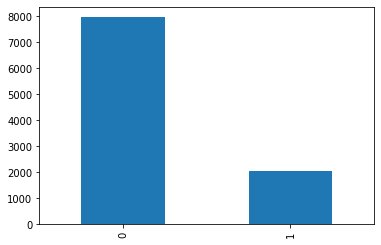

In [16]:
df['Exited'].value_counts().plot(kind='bar')
plt.show()

Дисбыланс 1/4. Не слишком сильный, но достаточный чтобы модель давала ложные предсказания. Построим матрицу ошибок.

In [17]:
confusion_matrix(target_valid, predicted_valid)

array([[1538,   54],
       [ 210,  198]])

В результате дисбаланса модель в основном делает TN предсказания. Воспользуемся другими метриками для оценки модели. Начнём с полноты, она выявляет, какую долю положительных среди всех ответов выделила модель.

In [18]:
recall_score(target_valid, predicted_valid, pos_label=1)

0.4852941176470588

Полнота — это доля TP-ответов среди всех, у которых истинная метка 1. В нашем случае модель может искать положительные ответы, но делает это недостаточно хорошо.

Показания "полноты" дополняет "точность". Точность определяет, как много отрицательных ответов нашла модель, пока искала положительные.

In [19]:
precision_score(target_valid, predicted_valid, pos_label=1)

0.7857142857142857

В данном случае точность модели 50% что говорит о низкой способности модели делать верные предсказания присваивая положительные метрики.

Для оценка полноты и точности есть агрегирующие метрики, к примеру - F1. Метрика показывает среднее гармоническое полноты и точности.

In [20]:
f1_score(target_valid, predicted_valid)

0.6

Для борьбы с дисбалансом можно увеличить или уменьшить выборку. Для некоторых моделей можно изменить порог классификации. Попробуем увеличить 1 класс и снизить 0 в выборке, т.е. выполнить up и down sampling.

In [21]:
confusion_matrix(target_valid, predicted_valid)

array([[1538,   54],
       [ 210,  198]])

In [22]:
target.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [23]:
def sample(features, target, repeat, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_sampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones] * repeat)
    target_sampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones] * repeat)
    
    features_sampled, target_sampled = shuffle(
        features_sampled, target_sampled, random_state=12345)
    
    return features_sampled, target_sampled

features_sampled, target_sampled = sample(features_train, target_train, 3, .8)

In [24]:
%%time
"""
# Код который использовался до ревью

model = RandomForestClassifier(random_state=12345)
model.fit(features_sampled, target_sampled)
predicted_valid = model.predict(features_valid)
accuracy_valid = accuracy_score(target_valid, predicted_valid)
accuracy_valid
"""


best_model = None
best_result = 0
best_depth = 0
best_est = 0

for depth in range(1, 12):
    for est in range(10, 100, 10):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_sampled, target_sampled)
        predict = model.predict(features_valid)
        result = f1_score(target_valid, predict)
        if result > best_result:
            best_model = model
            best_result = result
            best_depth = depth
            best_est = est

print(f'F1 лучшей модели {round(best_result, 2)},количество деревьев {best_est}, с глубиной дерева: {best_depth}')

F1 лучшей модели 0.65,количество деревьев 90, с глубиной дерева: 11
CPU times: user 20.7 s, sys: 68.1 ms, total: 20.8 s
Wall time: 20.8 s


In [25]:
f1_score(target_valid, predicted_valid)

0.6

В результате преобразований значение F-1 меры сдвинулось к 1 что говорит о повышении полноты.

Оценим качество модели метрикой AUC-ROC.

In [26]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

roc_auc_score(target_valid, probabilities_one_valid)

0.8687016577987978

Значение выше значения случайной модели. Это говорит о том что после балансировки данных модель стала обучатья эффективнее и показывать результаты выше, хоть и ненамного.

In [27]:
%%time

best_model_DTC = None
best_result_DTC = 0
best_depth_DTC = 0
best_leef = 0
best_split = 0

for depth in range(1, 10):
    for leaf in range(1, 5):
        for split in range(2, 8):
            model_DTC = DecisionTreeClassifier(
                random_state=12345, 
                max_depth=depth, 
                min_samples_leaf=leaf,
                min_samples_split=split)
            model_DTC.fit(features_sampled, target_sampled)
            predictions_DTC = model_DTC.predict(features_valid)
            result_DTC = f1_score(target_valid, predictions_DTC)
            if result_DTC > best_result_DTC:
                best_model_DTC = model_DTC
                best_result_DTC = result_DTC
                best_depth_DTC = depth
                best_leef = leaf
                best_split = split
            
print(
    f'F1 лучшей модели {round(best_result_DTC, 2)}, глубина дерева: {best_depth_DTC}, минимальное число образцов в листах {best_leef}, минимальное число образцов для сплита {best_split}')



F1 лучшей модели 0.59, глубина дерева: 6, минимальное число образцов в листах 1, минимальное число образцов для сплита 6
CPU times: user 4.04 s, sys: 8.05 ms, total: 4.04 s
Wall time: 4.05 s


In [28]:
probabilities_valid = model_DTC.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

roc_auc_score(target_valid, probabilities_one_valid)

0.8044619543797418

В результате видим что решающее дерево решает задачу быстрее даже с большим числом параметров, однако его точность остаётся ниже модели случайного леса.

## Тестирование модели

Перейдём к предсказаниям для тестовой выборки. Сначала проверим какие результаты даёт показавший себя хуже алгоритм решающего дерева.

F1 мера: 0.5506149479659413
AUC-ROC мера: 0.8140336021691954


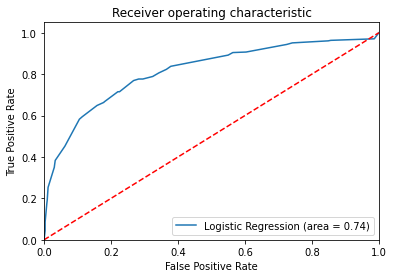

In [29]:
model = DecisionTreeClassifier(
    random_state=12345, 
    max_depth=6, 
    min_samples_leaf=1,
    min_samples_split=6)

model.fit(features_sampled, target_sampled)
predict = model.predict(features_test)
f1_score(target_test, predict)
print(f'F1 мера: {f1_score(target_test, predict)}')

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

print(f'AUC-ROC мера: {roc_auc_score(target_test, probabilities_one_test)}')

logit_roc_auc = roc_auc_score(target_test, predict)
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Точность предсказаний ниже чем в тех задании, вся надежда на алгоритм случайного леса.

In [30]:
model = RandomForestClassifier(n_estimators=90, max_depth=11, random_state=12345)
model.fit(features_sampled, target_sampled)
predict_test = model.predict(features_test)
print(f'F1 мера: {f1_score(target_test, predict_test)}')

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

print(f'Площадь под ROC кривой: {roc_auc_score(target_test, probabilities_one_test)}')

F1 мера: 0.6008869179600886
Площадь под ROC кривой: 0.85367031129743


F1 мера модели 0.6 что говорит о большей полноте, чем о точности. Площадь под ROC кривой для случайной модели 0.5, для нашей 0.85 что говорит о том что модель преимущественно делает верные предсказания, но не со 100% вероятностью.

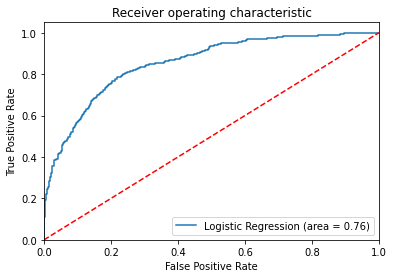

In [31]:
RFC_roc_auc = roc_auc_score(target_test, predict_test)
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % RFC_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

В ходе проекта мы прошли весь путь от получения данных, выболнения их предобработки, балансировки, стандартизации, обучения моделей и сравнения моделей, их оценку разными метриками до получения работоспособной модели. Основными критериями качества выбрали F1 как комплексную меру для оценки полноты и точности и AUC-ROC. График AUC-ROC показывает насколько точно наш алгоритм отличает True Positive от Fals Positive. Чем ближе значение площади под кривой к 1, тем точнее предсказания делает модель. Для учебного проекта была поставлена задача получить значение F1 не менее 0.59, наша модель выполняет данное условие.